In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext memory_profiler

In [3]:
import os
import gc
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt

from matplotlib import colors
from astropy.io import fits

from ics.hxutils import hxramp
from h4rg_analysis import io, ramputils

In [4]:
plt.rcParams['figure.figsize'] = (8,8)

In [190]:
bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]
pt = io.jhu2tiger ( bestbaselines[10] )
tag = os.path.basename(pt).strip('.fits')

In [6]:
import sys
sys.path.append('../scripts')
import do_simpleutr

In [191]:
%%memit -r1
ramp = hxramp.HxRamp( pt )

peak memory: 1642.59 MiB, increment: 0.01 MiB


In [10]:
#%%memit -r1
#ref = ramp.irpStack (dtype='f4') # IRP frames

In [193]:
ramp.interleaveOffset

0

In [192]:
%%memit -r1
ref_unsigned = ramp.irpStack () # IRP frames

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
ref_unsigned

In [83]:
step = 4096//10
slicey = slice(0,step)
slicex = slice(0,step)
ngrps = 300

In [90]:
%%time
sl_irp = io.irp_sliced ( ramp, slicey=slicey, slicex=slicex )
out = do_simpleutr.utrstats ( sl_irp )

CPU times: user 17.2 s, sys: 11.4 s, total: 28.5 s
Wall time: 41.5 s


In [98]:
out = do_simpleutr.utrstats ( sl_irp )

In [104]:
nbins=10
step = ramp.ncols // nbins
sl_indices = np.concatenate ( [np.arange(0, ramp.ncols, step)[:-1], [ramp.ncols+1]] )
slices = [ slice(sl_indices[idx], sl_indices[idx+1]) for idx in range(sl_indices.size-1) ]

In [174]:
slx = hxramp.constructFullIrp(ramp.fits[extname][cslice_y,cslice_x], ramp.nchan, refPix=ramp.interleaveOffset )

In [161]:
ref = io.irp_sliced ( ramp, r0=-1, slicey=cslice_y, slicex=cslice_x)

In [177]:
%%memit -r1
irp = ramp.irpStack ()

peak memory: 11277.42 MiB, increment: 9655.50 MiB


In [152]:
%%memit -r1
ramp.fits['REF_9'].read()[cslice_y,cslice_x]

peak memory: 1620.73 MiB, increment: 31.82 MiB


In [182]:
np.arange(0,len(bestbaselines),2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [188]:
np.arange(len(bestbaselines)//2)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [189]:
len(bestbaselines)//2

9

In [125]:
irp_var = np.load ( '../data/output/old/PFJB02402223_IRP_var.npy')
data_var = np.load( '../data/output/old/PFJB02402223_data_var.npy')

In [133]:
irp0 = np.load('../data/output/PFJB02402223/PFJB02402223_IRP_var0.npy')

In [139]:
cslice_y = slices[0]
cslice_x = slices[0]

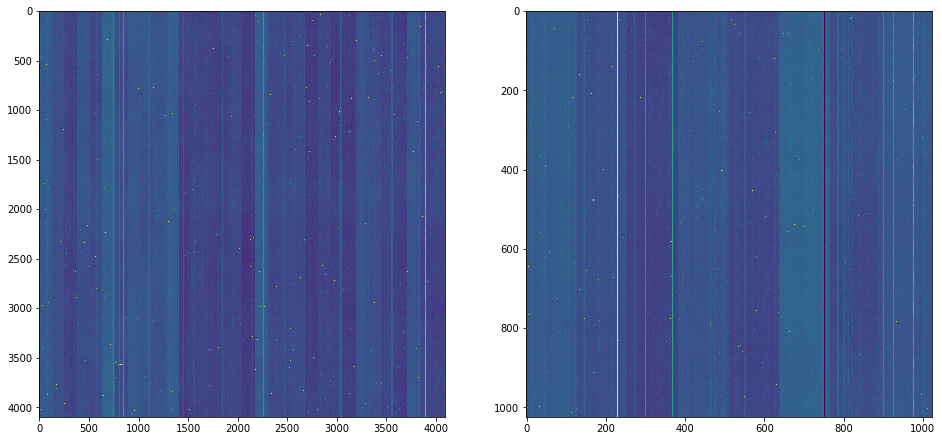

In [145]:
fig, axarr = plt.subplots(1,2, figsize=(16,8))

kwargs = {'vmin':1e2, 'vmax':1e3, 'norm':colors.LogNorm () }
axarr[0].imshow ( irp_var, **kwargs )
axarr[1].imshow ( irp0, **kwargs )

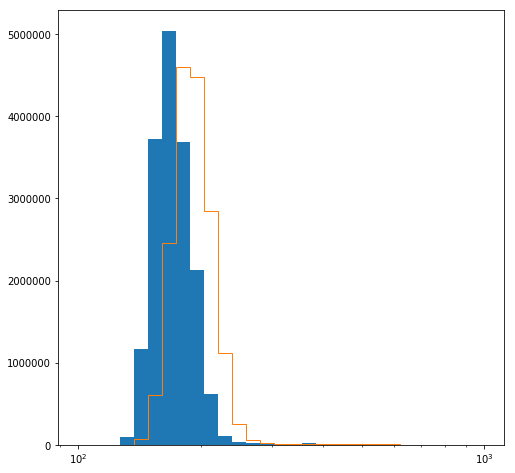

In [13]:
bins = np.logspace(2,3, 30)
plt.hist(irp_var.flatten(),bins=bins)
plt.hist(data_var.flatten(),bins=bins, histtype='step')
plt.xscale('log')

In [80]:
st = ramp.readN(10)

In [8]:
#%%time
#stack = ramp.readStack() # IRP-corrected

In [12]:
#\\ plt.figure(figsize=(12,3))
#\\ plt.plot(ref[1,0] - ref[1,10], label='Read 1')
#\\ plt.plot(ref[13,0] - ref[13,10], label='Read 13')
#\\ plt.legend()
#\\ plt.xlabel ( 'x' )
#\\ plt.ylabel ( '(row 1) - (row 10)')
#\\ plt.savefig('../figures/column_variation.png')

In [92]:
stop = 10
out = ramputils.utr_expectedflux ( ref, stop=stop )

In [96]:
np.array(out[1]).shape

(2, 10, 10)

In [94]:
out[1][1].shape

(10, 10)

In [66]:
flattened = ref[:,:stop,:stop] - expected_flux

In [67]:
var = np.var(flattened, axis=0)

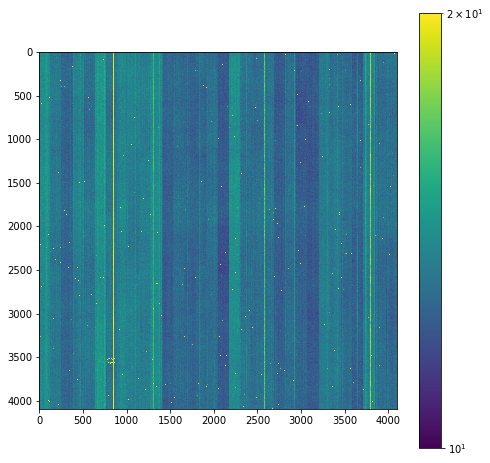

In [76]:
plt.imshow(np.sqrt(var), vmin=10.,vmax=20., norm=colors.LogNorm())
plt.colorbar()

In [69]:
print(pt)

/projects/HSC/PFS/JHU/ramps/2021-08-24/PFJB02402223.fits


(array([ 2.,  3.,  6., 10.,  4.,  0.,  4.,  4.,  2.,  1.]),
 array([16.366184, 16.833689, 17.301191, 17.768696, 18.236198, 18.703703,
        19.171207, 19.63871 , 20.106215, 20.573717, 21.041222],
       dtype=float32),
 <a list of 10 Patch objects>)

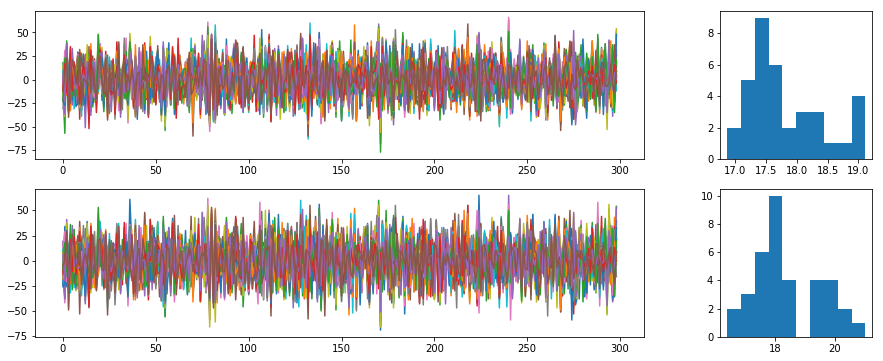

In [10]:
fig, axarr = plt.subplots(2,2,figsize=(15,6), gridspec_kw={'width_ratios':[4,1]})

steps = np.arange(0, 4096, 4096//5)
rvar = []
dvar = []
for ydx in steps:
    for xdx in steps:
        pixel = ref[:,ydx,xdx]
        axarr[0,0].plot(pixel[1:] - pixel[:-1])#, color='k', alpha=0.3)
        rvar.append(np.std(pixel[1:] - pixel[:-1]))
        
        pixel = data[:,ydx,xdx]
        axarr[1,0].plot ( pixel[1:] - pixel[:-1])
        dvar.append(np.std(pixel[1:] - pixel[:-1]))
        
axarr[0,1].hist(rvar)
axarr[1,1].hist(dvar)

In [128]:
refvar = np.std(utr,axis=0)

In [129]:
refvar.mean()

17.671198

In [94]:
nosubvar = np.var(ref-ref[0],axis=0)

In [104]:
from_data = np.var ( stack[1:] - stack[:-1], axis=0 )

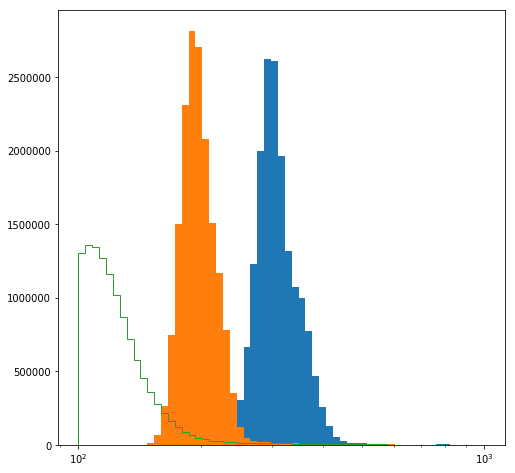

In [105]:
bins=np.logspace (2,3,60)
plt.hist ( refvar.flatten (), bins=bins )
plt.hist ( nosubvar.flatten (), bins=bins )
plt.hist ( from_data.flatten (), bins=bins, histtype='step' )
plt.xscale('log')

In [91]:
hdr = fits.getheader(pt, 0)